

# Project: Investigate Kaggle's European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling_matches">Data Wrangling: Matches</a></li>
<li><a href="#eda_matches">Exploratory Data Analysis: Matches</a></li>
<li><a href="#wrangling_players">Data Wrangling: Players</a></li>
<li><a href="#eda_players">Exploratory Data Analysis: Players</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='introduction'></a>
## Introduction

As a football fan, it was not hard to choose between the datasets provided for this project. Picking the most interesting research questions, however, was much more difficult: with dozens of variables for matches, teams and individual players, there are literally hundreds of questions to answer. After much thought, I decided to extract two datasets from the SQLite database (the SQL statements that I used are described in the next cell):

* Matches (league name, date, home team, away team and the goals scored for the respective teams)
* Players (a combination of the tables 'player' and 'player_attributes')

For these datasets, I will try to answer the following research questions:
1. Is there an advantage for teams playing in their own stadium (home advantage)?
2. How did the Spanish football club Barcelona perform over the years, compared to its main competitor Real Madrid?
3. Are there more professional football players born in the first months of the year than in the last months of the year ([relative age effect](https://en.wikipedia.org/wiki/Relative_age_effect))?
4. Are there player characteristics that correspond to higher overall rating in the EA Sports FIFA video game? 

The European Soccer database was stored in a SQLite database. I used the software 'DB Browser for SQLite' and the following SQL statements to extract the datasets I needed:

__Matches__

```mysql
SELECT l.name AS league_name, m.season, m.date, t1.team_long_name as home_team, t2.team_long_name AS away_team, m.home_team_goal, m.away_team_goal
FROM Match m
JOIN League l
ON m.league_id = l.id
INNER JOIN Team as t1
ON m.home_team_api_id = t1.team_api_id
INNER JOIN Team as t2
ON m.away_team_api_id = t2.team_api_id;
```

__Players__
``` mysql
SELECT *
FROM Player_Attributes pa
JOIN Player p
ON p.player_api_id = pa.player_api_id;
```

In [1]:
#Import statements for libraries needed for this project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import calendar

#Show visualisations in the notebook
% matplotlib inline

In [2]:
#Set display options in order the inspect the data in the extensive datasets properly
#This increases the default display options seen when exploring the dataframes - printing with head() etc...

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

<a id='wrangling_matches'></a>
## Data Wrangling: Matches

In [3]:
#Import dataset

matches = pd.read_csv('matches.csv')

In [4]:
#Visualize the first rows of the dataset matches
matches.head()


,league_name,season,date,home_team,away_team,home_team_goal,away_team_goal
0,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KRC Genk,Beerschot AC,1,1
1,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,KAA Gent,RAEC Mons,5,0
4,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3


### Duplicate rows in the matches dataset

In [5]:
#Find number of duplicate rows
sum(matches.duplicated())

0

There are no duplicate rows in the Matches dataframe, so no action needs to be taken.

### Number of samples & columns in the matches dataset

In [6]:
#Check if there are any null values in the dataframe
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 7 columns):
league_name       25979 non-null object
season            25979 non-null object
date              25979 non-null object
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
dtypes: int64(2), object(5)
memory usage: 1.4+ MB


25979 non-null object = 25979 entries, therefore no null values are found.

### Fixing Data Types

The dates in the column 'date' were strings when imported, we need to convert this column to datetime format.

In [7]:
#Column 'date' is currently a string, convert to datetime format
matches['date'] = pd.to_datetime(matches['date'])

In [8]:
#Create new column with day of week
matches['day_of_week'] = matches['date'].dt.weekday_name

Let us visualize the information and the first 5 rows of the dataset matches.

In [9]:
matches.info()
matches.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 8 columns):
league_name       25979 non-null object
season            25979 non-null object
date              25979 non-null datetime64[ns]
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
day_of_week       25979 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 1.6+ MB


,league_name,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week
0,Belgium Jupiler League,2008/2009,2008-08-17,KRC Genk,Beerschot AC,1,1,Sunday
1,Belgium Jupiler League,2008/2009,2008-08-16,SV Zulte-Waregem,Sporting Lokeren,0,0,Saturday
2,Belgium Jupiler League,2008/2009,2008-08-16,KSV Cercle Brugge,RSC Anderlecht,0,3,Saturday
3,Belgium Jupiler League,2008/2009,2008-08-17,KAA Gent,RAEC Mons,5,0,Sunday
4,Belgium Jupiler League,2008/2009,2008-08-16,FCV Dender EH,Standard de Liège,1,3,Saturday


### Further Data Preparation

To be able to make statements about the presumed advantage for teams playing in their home stadium, we need to create a new column for the "net score" column.

In [10]:
#Calculate the net score for each game. This new column will be used to determine if it is a home or away win (or draw)
net_score = matches['home_team_goal'] - matches['away_team_goal']
matches['net_score'] = net_score

In [11]:
#Visualize the first rows of the dataset matches
matches.head()


,league_name,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week,net_score
0,Belgium Jupiler League,2008/2009,2008-08-17,KRC Genk,Beerschot AC,1,1,Sunday,0
1,Belgium Jupiler League,2008/2009,2008-08-16,SV Zulte-Waregem,Sporting Lokeren,0,0,Saturday,0
2,Belgium Jupiler League,2008/2009,2008-08-16,KSV Cercle Brugge,RSC Anderlecht,0,3,Saturday,-3
3,Belgium Jupiler League,2008/2009,2008-08-17,KAA Gent,RAEC Mons,5,0,Sunday,5
4,Belgium Jupiler League,2008/2009,2008-08-16,FCV Dender EH,Standard de Liège,1,3,Saturday,-2


For the second research question regarding the football team Barcelona, we need to create a filtered dataframe.

We also have to add a new column to this dataframe based on the net score in which the number of points for Barcelona are calculated (in football, you receive 3 points for a win, 1 point for a draw and no points for a loss). We need to do the same for Barcelona's eternal competitor Real Madrid.

In [12]:
#Create separate dataframe with Barcelona matches only and do the same for the main competitor Real Madrid

# create two copies of the matches dataframe
barca = matches.copy()  # data on FC Barcelona matches 
madrid = matches.copy()  # data on Real Madrid matches

In [13]:
# Football club names to analyse
football_clubs = ['FC Barcelona', 'Real Madrid CF']


In [14]:
barca = barca[(barca.home_team == football_clubs[0]) | (barca.away_team == football_clubs[0])]
barca = barca.drop(columns=['league_name'])

barca.head()

,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week,net_score
21520,2008/2009,2008-08-31,CD Numancia,FC Barcelona,1,0,Sunday,1
21534,2008/2009,2008-11-08,FC Barcelona,Real Valladolid,6,0,Saturday,6
21546,2008/2009,2008-11-16,RC Recreativo,FC Barcelona,0,2,Sunday,-2
21549,2008/2009,2008-11-23,FC Barcelona,Getafe CF,1,1,Sunday,0
21563,2008/2009,2008-11-29,Sevilla FC,FC Barcelona,0,3,Saturday,-3


### Repeat process for Real Madrid

In [15]:
madrid = madrid[(madrid.home_team == football_clubs[1]) | (madrid.away_team == football_clubs[1])]
madrid = madrid.drop(columns=['league_name'])

madrid.head()



,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week,net_score
21519,2008/2009,2008-08-31,RC Deportivo de La Coruña,Real Madrid CF,2,1,Sunday,1
21533,2008/2009,2008-11-08,Real Madrid CF,Málaga CF,4,3,Saturday,1
21544,2008/2009,2008-11-15,Real Valladolid,Real Madrid CF,1,0,Saturday,1
21554,2008/2009,2008-11-22,Real Madrid CF,RC Recreativo,1,0,Saturday,1
21565,2008/2009,2008-11-29,Getafe CF,Real Madrid CF,3,1,Saturday,2


In [16]:
#Write function to calculate the number of points awarded for the team and match that is being investigated. 

#In football, 3 points are awarded for a win, 1 point for a draw and 0 points for a loss. 

def points(row, team):
    if (row['net_score'] > 0) and (row['home_team'] == team):
        return 3
    elif (row['net_score'] < 0) and (row['away_team'] == team):
        return 3
    elif (row['net_score'] > 0) and (row['away_team'] == team):
        return 0
    elif (row['net_score'] < 0) and (row['home_team'] == team):
        return 0
    else:
        return 1

In [17]:
#Create new column in the team dataframes that contains the number of points earned per match

barca['points_barca'] = barca.apply(lambda row: points(row, 'FC Barcelona'), axis=1)
madrid['points_madrid'] = madrid.apply(lambda row: points(row, 'Real Madrid CF'), axis=1)


In [18]:
#Visualize the first rows of the dataset madrid
madrid.head()


,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week,net_score,points_madrid
21519,2008/2009,2008-08-31,RC Deportivo de La Coruña,Real Madrid CF,2,1,Sunday,1,0
21533,2008/2009,2008-11-08,Real Madrid CF,Málaga CF,4,3,Saturday,1,3
21544,2008/2009,2008-11-15,Real Valladolid,Real Madrid CF,1,0,Saturday,1,0
21554,2008/2009,2008-11-22,Real Madrid CF,RC Recreativo,1,0,Saturday,1,3
21565,2008/2009,2008-11-29,Getafe CF,Real Madrid CF,3,1,Saturday,2,0


In [19]:
#Write function to calculate the number of goals for the team and match that is being investigated.
def goals(row, team):
    if row['home_team'] == team:
        return row['home_team_goal']
    else:
        return row['away_team_goal']

In [20]:
#Create new column in the team dataframes that contains the number of goals scored per match
barca['goals_barca'] = barca.apply(lambda row: goals(row, 'FC Barcelona'), axis=1)
madrid['goals_madrid'] = madrid.apply(lambda row: goals(row, 'Real Madrid CF'), axis=1)


In [21]:
#Visualize the first rows of the dataset barca
barca.head()


,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week,net_score,points_barca,goals_barca
21520,2008/2009,2008-08-31,CD Numancia,FC Barcelona,1,0,Sunday,1,0,0
21534,2008/2009,2008-11-08,FC Barcelona,Real Valladolid,6,0,Saturday,6,3,6
21546,2008/2009,2008-11-16,RC Recreativo,FC Barcelona,0,2,Sunday,-2,3,2
21549,2008/2009,2008-11-23,FC Barcelona,Getafe CF,1,1,Sunday,0,1,1
21563,2008/2009,2008-11-29,Sevilla FC,FC Barcelona,0,3,Saturday,-3,3,3


<a id='eda_matches'></a>
## Exploratory Data Analysis: Matches


### Research Question 1: Is there an advantage for teams playing in their own stadium?

In [22]:
#Explore contents of dataframe for reference
matches.head()

,league_name,season,date,home_team,away_team,home_team_goal,away_team_goal,day_of_week,net_score
0,Belgium Jupiler League,2008/2009,2008-08-17,KRC Genk,Beerschot AC,1,1,Sunday,0
1,Belgium Jupiler League,2008/2009,2008-08-16,SV Zulte-Waregem,Sporting Lokeren,0,0,Saturday,0
2,Belgium Jupiler League,2008/2009,2008-08-16,KSV Cercle Brugge,RSC Anderlecht,0,3,Saturday,-3
3,Belgium Jupiler League,2008/2009,2008-08-17,KAA Gent,RAEC Mons,5,0,Sunday,5
4,Belgium Jupiler League,2008/2009,2008-08-16,FCV Dender EH,Standard de Liège,1,3,Saturday,-2


In [23]:
#Descriptive statistics for the matches dataset
matches.describe()

,home_team_goal,away_team_goal,net_score
count,25979.000000,25979.000000,25979.000000
mean,1.544594,1.160938,0.383656
std,1.297158,1.142110,1.782403
min,0.000000,0.000000,-9.000000
25%,1.000000,0.000000,-1.000000
50%,1.000000,1.000000,0.000000
75%,2.000000,2.000000,1.000000
max,10.000000,9.000000,10.000000


If a home advantage does not exist, one would expect the mean net score to be zero. This would mean that on average, the same number of goals are scored by the home team and the away team.

The mean net score for this dataset, however, is 0.38. To see if this result is statistically significant, we will run a one sample t-test to compare the mean net score to the mean net score expected without home advantage (0).

The formula for the one sample t-test is:

  
$t = \frac{m-\mu}{s / \sqrt{n}}$


Using the mean and the standard deviation for net_score from the table above:

$t = \frac{0.383656-0}{1.782403/\sqrt{25979}} = 34.69$

Looking up this value in a ([T-Distribution table](http://www.statisticshowto.com/tables/t-distribution-table/)) we learn that the p-value for this score is lower than the lowest p-value in the table. By conventional criteria, this difference in net score is considered to be statistically significant, so, it would be safe to assert that the null hypothesis of there being no home advantage is false and that there is indeed an advantage for teams playing in their home stadium.

More information on [statistical significance](https://www.statisticssolutions.com/manova-analysis-one-sample-t-test/)
may be found in the link provided.


Although the phenomenon of home advantage is widely known in many sports, there is still much debate about the underlying reasons for it. Is it the cheering crowd, the familiarity of the stadium, the fact that players do not have to travel, or even the [referee](https://www.researchgate.net/publication/259824788_Home_advantage_and_referee_bias_in_European_football) who may be biased?

[One researcher](http://onlinelibrary.wiley.com/doi/10.1111/ecin.12465/full) even suggested that the home advantage for teams in the German Bundesliga dissapears when a match is played in the middle of the week. 

In [24]:
matches[(matches.league_name == 'Germany 1. Bundesliga') & ((matches.day_of_week == 'Tuesday') | (matches.day_of_week == 'Wednesday') | (matches.day_of_week == 'Thursday'))].describe()

,home_team_goal,away_team_goal,net_score
count,115.000000,115.000000,115.000000
mean,1.617391,1.382609,0.234783
std,1.288155,1.203668,1.992664
min,0.000000,0.000000,-5.000000
25%,1.000000,0.000000,-1.000000
50%,1.000000,1.000000,0.000000
75%,2.000000,2.000000,2.000000
max,5.000000,5.000000,5.000000


Indeed, the average net score is lower when playing matches on Tuesday, Wednesday or Thursday (but so is the sample size) and it may be observed that the home advantage does not dissapear completely. This is at least true for matches for the German Bundesliga period 2008-2016. Or is this perhaps not true?

Let us verify if the results obtained are statistically significant so that we could support or reject the null hypothesis and back up the researcher's conclusion.

Following the same procedure as above, the test statistic (t-value) is calculated and its p-value is obtained.

$t = \frac{0.234783-0}{1.992664/\sqrt{115}} = 1.2635$

Again, by looking up this value in a ([T-Distribution table](http://www.statisticshowto.com/tables/t-distribution-table/)) we learn that, in this case, the p-value for this score is higher than the highest p-value in the table. If the cutoff value for determining statistical significance is determined to be 0.05, this would correspond to a 5% (or less) chance of obtaining a result like the one that would be observed if the null hypothesis was true. Since our p-value obtained is higher than 10%, it would be difficult to refute the null hypothesis of there being **no home advantage when a match is played in the middle of the week for teams in the German Bundesliga.**

The results obtained do indeed align with the reseacher's suggestion.


## Could the same apply for the rest of football matches at a worldwide level ?

***Explore in the future.***

The extent to which the home advantage occurs varies between the leagues in the dataset. It would be plausible to expect that the home advantage is greater when the distances between home and away clubs are considerably long.



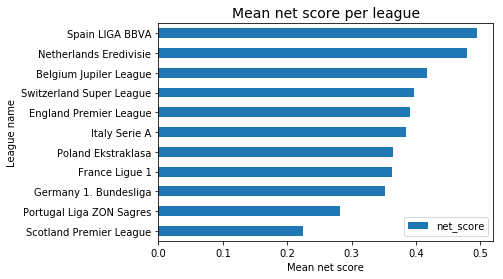

In [25]:
#Create bar chart for the net score per league

mean_net_score = matches.pivot_table(index='league_name', values='net_score', aggfunc=np.mean)

sorted_scores = mean_net_score.sort_values(by='net_score', ascending=True)

ax = sorted_scores.plot.barh()

ax.set_xlabel("Mean net score")
ax.set_ylabel("League name")
ax.grid(False)
plt.title('Mean net score per league', fontsize=14);

However, looking at the chart above, this seems not the case. Although the lowest mean net score is seen in the relative small country of Scotland (which would fit the hypothesis), two of the highest mean net scores are observed in the Netherlands and Belgium, the latter being the smallest country in the dataset.

### Research Question 2: How did FC Barcelona perform over the years, compared to its main competitor Real Madrid?

In Spain, the highest football league "La Liga" is historically dominated by two clubs: FC Barcelona and Real Madrid CF. The question is then; how did FC Barcelona perform in terms of the number of points earned per season and the number of goals scored compared to its eternal rival?

In [26]:
#Create a combined dataframe of pivot tables, in order to compare the number of points earned per season

points_barca = barca.pivot_table(index='season', values=['points_barca'],aggfunc=np.sum) 
points_madrid = madrid.pivot_table(index='season', values=['points_madrid'],aggfunc=np.sum)

#Store pivot-tables(dataframes) in an list
dfs = [points_barca, points_madrid]

combined_points = pd.concat(dfs, axis=1)

In [27]:
#Visualize the first rows (8) of the dataset combined_points
combined_points.head(8)


,points_barca,points_madrid
season,,
2008/2009,87,78
2009/2010,99,96
2010/2011,96,92
2011/2012,91,100
2012/2013,100,85
2013/2014,87,87
2014/2015,94,92
2015/2016,91,90


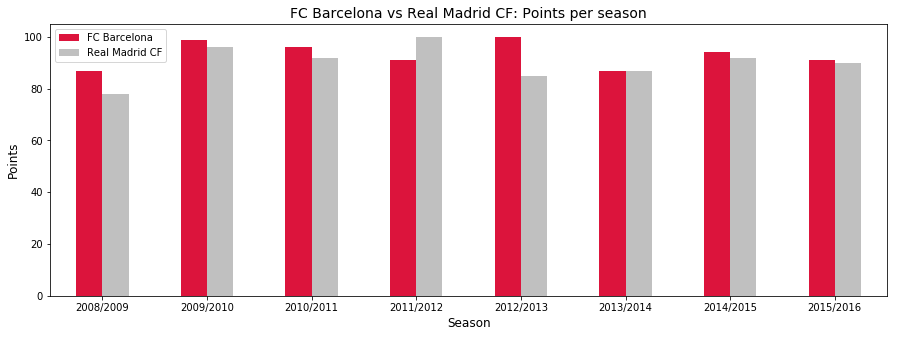

In [28]:
#Create grouped bar chart for the total number of points per season, for each team

labels = ['FC Barcelona', 'Real Madrid CF']

ax = combined_points.plot(kind='bar', figsize=(15,5), rot=0, color=['crimson', 'silver'])
ax.legend(labels)
ax.grid(False)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Points', fontsize=12)
plt.title('FC Barcelona vs Real Madrid CF: Points per season', fontsize=14);

Over the the 2008 and 2016 seasons, it may be deduced that FC Barcelona was the overall winner with regards to the number of points earned. 


In [29]:
#Create a combined dataframe of pivot tables, in order to compare the number of goals scored per season for each team

goals_barca = barca.pivot_table(index='season', values=['goals_barca'],aggfunc=np.sum) 
goals_madrid = madrid.pivot_table(index='season', values=['goals_madrid'],aggfunc=np.sum)

#Store pivot-tables(dataframes) in an list
dfs_goals = [goals_barca, goals_madrid]

#Join the columns
combined_goals = pd.concat(dfs_goals, axis=1)

combined_goals.head(10)

,goals_barca,goals_madrid
season,,
2008/2009,105,83
2009/2010,98,102
2010/2011,95,102
2011/2012,114,121
2012/2013,115,103
2013/2014,100,104
2014/2015,110,118
2015/2016,112,110


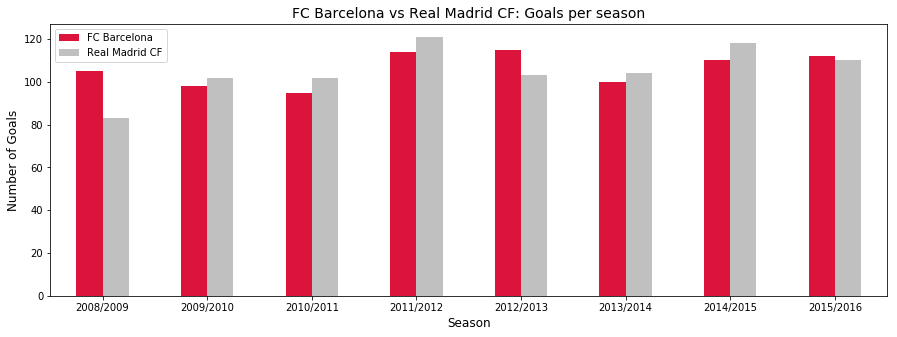

In [30]:
#Create grouped bar chart for the total number of goals per season, per team

ax = combined_goals.plot(kind='bar', figsize=(15,5), rot=0, color=['crimson', 'silver'] )

ax.legend(labels, loc='upper left')

ax.grid(False)

plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Goals', fontsize=12)
plt.title('FC Barcelona vs Real Madrid CF: Goals per season', fontsize=14);

The bar-chart shows that the club that scored the most goals is not the same as per the champion in terms of points per season. In fact, Real Madrid CF has scored more goals than FC Barcelona during 5 seasons, whereas FC Barcelona has scored more goals than Real Madrid CF during 3 seasons (which happen to also coincide with seasons in which they have been champions in terms of points per season).

True to their famous offensive playing style, it comes as no surprise that Real Madrid CF is responsible for the most goals in one season in this dataset: 121 goals in season 2011/2012 (the season in which the title was also grabbed by Real Madrid). 

<a id='wrangling_players'></a>
## Data Wrangling: Players

In [31]:
#load player data
players = pd.read_csv('player_names_attributes.csv', index_col='id')

In [32]:
#Visualize the first rows of the dataset players
players.head(6)


,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,id.1,player_api_id.1,player_name,player_fifa_api_id.1,birthday,height,weight
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
6,189615,155782,2016-04-21 00:00:00,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146


In [33]:
#To make the dataframe a bit more manageable, columns that will not be used are dropped

players = players.drop(columns=['player_fifa_api_id', 'player_api_id', 'id.1', 'player_api_id.1', 'player_fifa_api_id.1'])

### Duplicate rows in the matches dataset

In [34]:
#Count number of duplicate rows and drop duplicates
sum(players.duplicated())

1

There is one duplicate row in the players dataframe, let us drop that one row. 

In [35]:
#Drop duplicates
players.drop_duplicates(inplace=True)

### Number of samples & columns in the players dataset

In [36]:
#Check if there are any null values in the dataframe
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183977 entries, 1 to 183978
Data columns (total 43 columns):
date                   183977 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint_speed           183142 non-null float64
agility                181265 non-null float64


183142 non-null object and 183977 entries, therefore some no-null values are found.

In [37]:
#Find number of rows with missing values per column
players.isnull().sum()

date                      0
overall_rating          835
potential               835
preferred_foot          835
attacking_work_rate    3229
defensive_work_rate     835
crossing                835
finishing               835
heading_accuracy        835
short_passing           835
volleys                2712
dribbling               835
curve                  2712
free_kick_accuracy      835
long_passing            835
ball_control            835
acceleration            835
sprint_speed            835
agility                2712
reactions               835
balance                2712
shot_power              835
jumping                2712
stamina                 835
strength                835
long_shots              835
aggression              835
interceptions           835
positioning             835
vision                 2712
penalties               835
marking                 835
standing_tackle         835
sliding_tackle         2712
gk_diving               835
gk_handling         

In the players dataset that originally contains more than 183.000 rows, there are 3229 rows that contain null values. Since I would like to make statements about larger groups of players (as opposed to making sure that every individual player is present in the dataset) let us drop all rows with null values. 

In [38]:
#Drop rows with missing values
players.dropna(axis=0, how='any', inplace=True)


In [39]:
#Running players.info() again, we learn that every column now has the same number (180354) of non-null values.
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 1 to 183978
Data columns (total 43 columns):
date                   180354 non-null object
overall_rating         180354 non-null float64
potential              180354 non-null float64
preferred_foot         180354 non-null object
attacking_work_rate    180354 non-null object
defensive_work_rate    180354 non-null object
crossing               180354 non-null float64
finishing              180354 non-null float64
heading_accuracy       180354 non-null float64
short_passing          180354 non-null float64
volleys                180354 non-null float64
dribbling              180354 non-null float64
curve                  180354 non-null float64
free_kick_accuracy     180354 non-null float64
long_passing           180354 non-null float64
ball_control           180354 non-null float64
acceleration           180354 non-null float64
sprint_speed           180354 non-null float64
agility                180354 non-null float64


As the S.I. unit of weight is the kilogram, let us convert the column "weight" to kilograms instead of the current lbs.

In [40]:
#Create new column 'weight_kg' that contains the player's weight in kilograms

weight_kg = players['weight'] * 0.45359237

players['weight_kg'] = weight_kg

Let us add a column 'BMI' (Body Mass Index) to have a little more information about the "healthy" ratio between weight and height.

In [41]:
#Calculate BMI with the following formula: weight in kilograms/height**2  (meters squared)

bmi = players['weight_kg']/(players['height']/100)**2

players['bmi'] = bmi

In [42]:
#Visualize the first 6 rows of the dataset players
players.head(6)


,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,84.821773,25.361499
2,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,84.821773,25.361499
3,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,84.821773,25.361499
4,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,84.821773,25.361499
5,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,84.821773,25.361499
6,2016-04-21 00:00:00,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,66.224486,22.866598


### Fixing Data Types

To be able to compare the ages of players, we first need to convert every row in the column 'birthday' to a datetime object and create a new column "age" from that. I borrowed the code for calculating the age at time of measurement [here](https://stackoverflow.com/questions/34279378/python-pandas-apply-function-with-two-arguments-to-columns) and [here](https://stackoverflow.com/questions/765797/python-timedelta-in-years).

In [43]:
#Function to calculate the age of the player on the rating date

players['birthday'] = pd.to_datetime(players['birthday'])
players['date'] = pd.to_datetime(players['date'])

def num_years(start, end):
    num_years = int((end - start).days / 365.25)
    return num_years
    
players['age'] = players.apply(lambda row: num_years(row['birthday'], row['date']), axis=1)

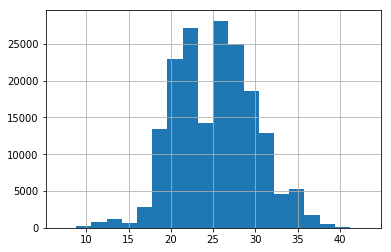

In [44]:
#Produce histogram with quantity of players per age group
players['age'].hist(bins=20);


Carefully observing the distribution of player's ages within the newly created column 'age', it seems that there are players younger than 15 or even 10 years old at the time of ranking. As this is not possible for professional football players, we will run a query on the players younger than 15 (see cell below). 

In [45]:
players.query('age < 15')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2007-02-22,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,14
146,2007-02-22,60.0,77.0,right,medium,high,47.0,31.0,46.0,63.0,33.0,53.0,55.0,39.0,63.0,62.0,72.0,67.0,60.0,60.0,80.0,52.0,71.0,68.0,59.0,37.0,74.0,54.0,50.0,58.0,41.0,51.0,56.0,56.0,7.0,12.0,13.0,13.0,14.0,Aaron Kuhl,1996-01-30,172.72,146,66.224486,22.198996,11
179,2007-02-22,48.0,57.0,right,medium,medium,12.0,15.0,16.0,23.0,14.0,15.0,14.0,18.0,18.0,22.0,15.0,26.0,31.0,45.0,24.0,26.0,38.0,18.0,44.0,12.0,21.0,19.0,14.0,15.0,41.0,15.0,15.0,12.0,53.0,41.0,39.0,51.0,53.0,Aaron Lennox,1993-02-19,190.50,181,82.100219,22.623217,14
317,2007-02-22,55.0,63.0,left,medium,medium,54.0,51.0,42.0,60.0,41.0,52.0,44.0,42.0,51.0,51.0,65.0,66.0,62.0,52.0,60.0,53.0,52.0,56.0,40.0,51.0,48.0,29.0,51.0,54.0,54.0,42.0,46.0,44.0,10.0,12.0,7.0,13.0,8.0,Aaron Splaine,1996-10-13,172.72,163,73.935556,24.783811,10
459,2007-02-22,63.0,72.0,left,medium,medium,42.0,52.0,39.0,64.0,40.0,72.0,67.0,45.0,56.0,67.0,75.0,78.0,82.0,62.0,72.0,48.0,65.0,62.0,53.0,52.0,40.0,23.0,46.0,64.0,46.0,32.0,33.0,40.0,8.0,13.0,8.0,15.0,8.0,Abdelmalek El Hasnaoui,1994-02-09,180.34,159,72.121187,22.175771,13
500,2007-02-22,62.0,70.0,left,medium,medium,41.0,29.0,60.0,58.0,36.0,46.0,40.0,31.0,43.0,49.0,59.0,64.0,46.0,50.0,64.0,41.0,73.0,68.0,55.0,23.0,58.0,61.0,29.0,32.0,40.0,64.0,70.0,67.0,11.0,6.0,6.0,6.0,7.0,Abdou Diallo,1996-05-04,182.88,159,72.121187,21.564055,10
532,2007-02-22,63.0,66.0,right,medium,medium,34.0,29.0,55.0,56.0,31.0,35.0,26.0,29.0,32.0,51.0,59.0,71.0,47.0,55.0,25.0,40.0,65.0,52.0,95.0,26.0,48.0,58.0,27.0,30.0,46.0,62.0,68.0,63.0,8.0,10.0,12.0,11.0,14.0,Abdoul Ba,1994-02-08,200.66,212,96.161582,23.882511,13
714,2007-02-22,57.0,75.0,right,medium,medium,23.0,23.0,23.0,39.0,36.0,23.0,14.0,9.0,47.0,28.0,42.0,32.0,57.0,70.0,58.0,45.0,66.0,46.0,55.0,23.0,23.0,30.0,18.0,33.0,22.0,23.0,23.0,20.0,58.0,59.0,47.0,39.0,74.0,Abdoulaye Diallo,1992-03-30,187.96,174,78.925072,22.340049,14
732,2007-02-22,55.0,72.0,right,medium,medium,47.0,32.0,53.0,59.0,23.0,51.0,28.0,30.0,52.0,56.0,63.0,57.0,68.0,52.0,62.0,51.0,71.0,54.0,58.0,28.0,62.0,58.0,35.0,47.0,44.0,43.0,61.0,57.0,14.0,11.0,11.0,14.0,13.0,Abdoulaye Doucoure,1993-01-01,182.88,165,74.842741,22.377793,14


It seems that there might be a problem with one of the ranking dates (February 22, 2007). Therefore, when I want to investigate age later in this report, I will leave out the measurements of February 2007. I do not prefer to drop these rows because assuming the original data's integrity to be of impeccable standards there should be no problem with the rest of the data. **I suspect that these players at the time were spotted as future-to-be football stars, hence the reason as to why they were included in the dataset** Maybe even EA FIFA Sports is monitoring future potential football player stars to see if there are any patterns that can better identify them early on in their promising career.

### Further Data Preparation

In [46]:
#Create new column with birth month (research question 3)

players['birth_month'] = players['birthday'].dt.month

In [47]:
#Visualize the first rows of the dataset players
players.head()


,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,23,2
2,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,23,2
3,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,23,2
4,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,23,2
5,2007-02-22,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,14,2


In [48]:
#Create dataframe with unique players to count every birthday just once

unique_players = players.copy()

unique_players.drop_duplicates(['player_name'], inplace=True)

In [49]:
#Visualize the first rows of the dataset of unique players
unique_players.head()


,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,23,2
6,2016-04-21,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,Aaron Cresswell,1989-12-15,170.18,146,66.224486,22.866598,26,12
39,2016-01-07,65.0,67.0,right,medium,medium,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,62.0,67.0,77.0,74.0,85.0,51.0,92.0,61.0,65.0,66.0,71.0,57.0,60.0,55.0,64.0,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0,Aaron Doran,1991-05-13,170.18,163,73.935556,25.529147,24,5
65,2016-04-21,69.0,69.0,right,medium,medium,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,59.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,Aaron Galindo,1982-05-08,182.88,198,89.811289,26.853352,33,5
88,2015-12-24,70.0,70.0,right,medium,medium,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,Aaron Hughes,1979-11-08,182.88,154,69.853225,20.885940,36,11


In [50]:
#Create a column with the string of the player's birth month

unique_players['birth_month_string'] = unique_players['birth_month'].apply(lambda row: calendar.month_abbr[row])

In [51]:
#Visualize the first rows of the dataset of unique players
unique_players.head()


,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month,birth_month_string
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,Aaron Appindangoye,1992-02-29,182.88,187,84.821773,25.361499,23,2,Feb
6,2016-04-21,74.0,76.0,left,high,medium,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,Aaron Cresswell,1989-12-15,170.18,146,66.224486,22.866598,26,12,Dec
39,2016-01-07,65.0,67.0,right,medium,medium,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,62.0,67.0,77.0,74.0,85.0,51.0,92.0,61.0,65.0,66.0,71.0,57.0,60.0,55.0,64.0,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0,Aaron Doran,1991-05-13,170.18,163,73.935556,25.529147,24,5,May
65,2016-04-21,69.0,69.0,right,medium,medium,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,59.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,Aaron Galindo,1982-05-08,182.88,198,89.811289,26.853352,33,5,May
88,2015-12-24,70.0,70.0,right,medium,medium,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,Aaron Hughes,1979-11-08,182.88,154,69.853225,20.885940,36,11,Nov


<a id='eda_players'></a>
## Exploratory Data Analysis: Players


### Research Question 3:  Are there more professional football players born in the first months of the year than in the last months of the year? 

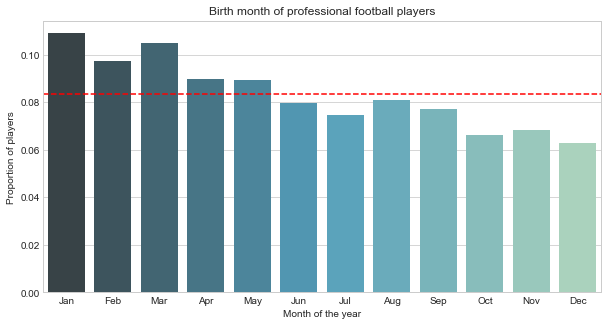

In [52]:
#Create barplot with the proportion of players born in a specific month

#Returns a panda series that is sorted by the highest value of counts and NOT by index (i.e the birth month)
counts = unique_players['birth_month'].value_counts(normalize=True)

#Fix the above by sorting counts by index so that we have the proportion corresponding to each month of the year
#respecting the gregorian calendar order

counts_ordered = counts.sort_index()


months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep","Oct", "Nov", "Dec"]
mean = 1/12

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x=months, y=counts_ordered, palette='GnBu_d')

plt.xlabel("Month of the year")
plt.ylabel("Proportion of players")
plt.title('Birth month of professional football players')

plt.axhline(mean, color='r', linestyle='--', label='mean');


On Wikipedia, the relative age effect is defined as follows:

> The term relative age effect (RAE) is used to describe a bias, evident in the upper echelons of youth sport and academia, where participation is higher amongst those born early in the relevant selection period (and correspondingly lower amongst those born late in the selection period) than would be expected from the normalised distribution of live births. 

In Europe, the selection year for football starts at January 1st. Therefore, if a relative age effect is present, an overrepresentation of birth months in the first quarter of the year is expected. Looking at the bar chart above, this trend is indeed visible. Unfortunately, at this point during my study, I cannot determine whether this difference is significant or if this observed distribution is due to chance. Nevertheless, as many researchers have demonstrated the existence of the relative age effect both in sports and education, the trend in the chart above does seem to indicate that an age effect exists for the professional football players in the dataset. 

In [53]:
#Show counts
counts


1     0.108938
3     0.105026
2     0.097203
4     0.089576
5     0.089380
8     0.080774
6     0.079601
9     0.077058
7     0.074809
11    0.068257
10    0.066399
12    0.062977
Name: birth_month, dtype: float64

In [54]:
#Show counts_ordered
counts_ordered


1     0.108938
2     0.097203
3     0.105026
4     0.089576
5     0.089380
6     0.079601
7     0.074809
8     0.080774
9     0.077058
10    0.066399
11    0.068257
12    0.062977
Name: birth_month, dtype: float64


### Research Question 4: Are there player characteristics that correspond to higher overall rating in the EA Sports FIFA video game?

In [55]:
#Visualize the descriptive statistics of the players dataset
players.describe()


,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight,weight_kg,bmi,age,birth_month
count,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.00000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000
mean,68.635317,73.479457,55.142071,49.962136,57.263476,62.486726,49.488927,59.265755,53.001408,49.392783,57.084578,63.453846,67.709405,68.101628,65.995082,66.148297,65.190082,61.866474,66.977333,67.053401,67.432477,53.387560,60.946217,51.897374,55.730730,57.868176,54.933448,46.757433,50.354065,48.029342,14.696685,15.947786,20.526304,16.015043,16.32531,181.877895,168.774593,76.554868,23.117492,25.161993,5.961204
std,7.027950,6.581963,17.247231,19.041760,16.478716,14.172493,18.252319,17.741351,18.245476,17.820262,14.412035,15.187692,13.011580,12.585984,12.963670,9.145011,13.076192,16.129537,11.017828,13.200669,12.085131,18.370204,16.101618,19.483338,18.458218,15.152408,15.556645,21.226730,21.496289,21.592830,16.841454,15.841297,21.143898,16.070772,17.18545,6.398588,15.098388,6.848513,1.337586,4.719768,3.434750
min,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,3.000000,5.000000,10.000000,12.000000,11.000000,17.000000,12.000000,2.000000,14.000000,10.000000,10.000000,1.000000,6.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,157.480000,117.000000,53.070307,17.868393,7.000000,1.000000
25%,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,52.000000,41.000000,36.000000,49.000000,59.000000,61.000000,62.000000,58.000000,61.000000,58.000000,54.000000,60.000000,61.000000,60.000000,41.000000,51.000000,34.000000,45.000000,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.00000,177.800000,159.000000,72.121187,22.175771,22.000000,3.000000
50%,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,64.000000,56.000000,50.000000,59.000000,67.000000,69.000000,69.000000,68.000000,67.000000,67.000000,66.000000,68.000000,69.000000,69.000000,58.000000,64.000000,56.000000,60.000000,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.00000,182.880000,168.000000,76.203518,23.100858,25.000000,6.000000
75%,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,72.000000,67.000000,63.000000,67.000000,73.000000,77.000000,77.000000,75.000000,72.000000,74.000000,73.000000,74.000000,76.000000,76.000000,67.000000,73.000000,68.000000,69.000000,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.00000,185.420000,179.000000,81.193034,23.988885,28.000000,9.000000
max,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,97.000000,97.000000,97.000000,97.000000,96.000000,96.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,95.000000,97.000000,96.000000,94.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.00000,208.280000,243.000000,110.222946,30.865728,43.000000,12.000000


In general, you can quickly see that there is a lot of variation in the mean and standard deviation across the various FIFA attributes. But the dry numbers become much more interesting (at least to me) when you realize that behind every extreme value, there are names of real players. For example, the world of difference between the top player with overall ranking of 94 (FC Barcelona's Lionel Messi) and the one with the lowest ranking (the Italian player Francesco Della Rocco who, fortunately for him, was very young when his first ranking was set and later reached an overall rating of 68 (__[source](https://sofifa.com/player/178043)__). The best header (the rather unknown Nicola Zigic), the most agile player (again, Lionel Messi amongst others), the most aggressive player (not surprisingly: Gennaro Gattuso, amongst others) and the one who scores penalties best (Rickie Lambert)... it is tempting to connect all attributes to names. 

There is also a lot of variation in age, weight and height. For age, there is probably an error in the data because the minimum age is 7 in the dataset. I will deal with this problem before making statements about age.

To conclude, the tallest player in the set is Kristof van Hout, a Belgian goalkeeper who measures 2.08 meters and is also the heaviest player. The smallest player is Juan Quero, a Spanish midfielder, who is -with his 53 kilograms- also the lightest player in the set.  

In [56]:
#Find names for extreme values from the descriptive statistics table
players.query('overall_rating == 94')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
102483,2015-12-17,94.0,94.0,left,medium,low,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,79.0,96.0,95.0,90.0,92.0,92.0,95.0,80.0,68.0,75.0,59.0,88.0,48.0,22.0,90.0,90.0,74.0,13.0,23.0,21.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,28,6
102484,2015-10-16,94.0,94.0,left,medium,low,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,79.0,96.0,95.0,90.0,92.0,92.0,95.0,80.0,68.0,75.0,59.0,88.0,48.0,22.0,90.0,90.0,74.0,13.0,23.0,21.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,28,6
102485,2015-09-21,94.0,95.0,left,medium,low,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,79.0,96.0,95.0,90.0,92.0,92.0,95.0,80.0,68.0,76.0,59.0,88.0,48.0,22.0,90.0,90.0,74.0,13.0,23.0,21.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,28,6
102492,2014-04-25,94.0,97.0,left,medium,low,84.0,97.0,71.0,89.0,90.0,97.0,87.0,86.0,76.0,96.0,96.0,88.0,94.0,96.0,95.0,81.0,73.0,78.0,60.0,88.0,48.0,22.0,93.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,26,6
102493,2013-11-15,94.0,97.0,left,high,medium,84.0,97.0,71.0,89.0,90.0,97.0,87.0,86.0,76.0,96.0,96.0,88.0,94.0,96.0,95.0,81.0,73.0,78.0,60.0,88.0,48.0,22.0,93.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,26,6
102494,2013-09-20,94.0,97.0,left,high,medium,84.0,97.0,71.0,89.0,90.0,97.0,87.0,86.0,76.0,96.0,96.0,88.0,94.0,96.0,95.0,81.0,73.0,78.0,60.0,88.0,48.0,22.0,93.0,90.0,76.0,25.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,26,6
102495,2013-03-22,94.0,97.0,left,high,medium,84.0,97.0,72.0,89.0,89.0,97.0,87.0,86.0,76.0,96.0,95.0,91.0,94.0,96.0,95.0,80.0,73.0,80.0,65.0,88.0,48.0,22.0,93.0,90.0,78.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,25,6
102496,2013-03-08,94.0,97.0,left,high,medium,84.0,97.0,72.0,89.0,89.0,97.0,87.0,86.0,76.0,96.0,95.0,91.0,94.0,96.0,95.0,80.0,73.0,80.0,65.0,88.0,48.0,22.0,93.0,90.0,78.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,25,6
102497,2013-02-15,94.0,97.0,left,high,medium,84.0,97.0,72.0,89.0,89.0,97.0,87.0,86.0,76.0,96.0,95.0,91.0,94.0,96.0,95.0,80.0,73.0,80.0,65.0,88.0,48.0,22.0,93.0,90.0,78.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,Lionel Messi,1987-06-24,170.18,159,72.121187,24.902665,25,6


In [57]:
players.query('overall_rating == 33')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
57834,2007-08-30,33.0,53.0,right,medium,medium,28.0,39.0,39.0,29.0,49.0,30.0,57.0,48.0,28.0,47.0,51.0,59.0,66.0,61.0,69.0,28.0,59.0,28.0,32.0,43.0,29.0,28.0,40.0,49.0,30.0,20.0,23.0,22.0,4.0,20.0,28.0,20.0,20.0,Francesco Della Rocca,1987-09-14,182.88,161,73.028372,21.835301,19,9
57835,2007-02-22,33.0,53.0,right,medium,medium,28.0,39.0,39.0,29.0,49.0,30.0,57.0,48.0,28.0,47.0,51.0,59.0,66.0,61.0,69.0,28.0,59.0,28.0,32.0,43.0,29.0,28.0,40.0,49.0,30.0,20.0,23.0,22.0,4.0,20.0,28.0,20.0,20.0,Francesco Della Rocca,1987-09-14,182.88,161,73.028372,21.835301,19,9


In [58]:
players.query('heading_accuracy == 98')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
134056,2007-02-22,79.0,92.0,right,low,medium,68.0,97.0,98.0,81.0,81.0,74.0,60.0,86.0,76.0,75.0,74.0,57.0,64.0,77.0,77.0,72.0,85.0,80.0,80.0,57.0,73.0,70.0,89.0,70.0,86.0,48.0,56.0,29.0,9.0,8.0,76.0,15.0,12.0,Nikola Zigic,1980-09-25,203.2,212,96.161582,23.28918,26,9


In [59]:
players.query('aggression == 97')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
62269,2009-02-22,83.0,90.0,right,medium,high,68.0,21.0,62.0,84.0,54.0,64.0,39.0,45.0,78.0,74.0,75.0,70.0,61.0,82.0,80.0,71.0,58.0,94.0,89.0,24.0,97.0,87.0,85.0,68.0,88.0,83.0,93.0,87.0,11.0,21.0,78.0,21.0,21.0,Gennaro Gattuso,1978-01-09,177.80,170,77.110703,24.392210,31,1
62270,2008-08-30,82.0,90.0,right,medium,high,68.0,21.0,62.0,82.0,54.0,64.0,39.0,45.0,75.0,74.0,75.0,70.0,61.0,82.0,80.0,71.0,58.0,94.0,87.0,24.0,97.0,87.0,85.0,68.0,83.0,79.0,93.0,87.0,11.0,21.0,75.0,21.0,21.0,Gennaro Gattuso,1978-01-09,177.80,170,77.110703,24.392210,30,1
83808,2008-08-30,75.0,82.0,right,medium,medium,69.0,59.0,65.0,75.0,70.0,64.0,57.0,74.0,70.0,78.0,70.0,74.0,62.0,75.0,72.0,74.0,71.0,89.0,82.0,76.0,97.0,75.0,74.0,76.0,69.0,55.0,84.0,76.0,11.0,22.0,70.0,22.0,22.0,Joey Barton,1982-09-02,180.34,154,69.853225,21.478420,25,9
83809,2007-08-30,81.0,81.0,right,medium,medium,74.0,73.0,67.0,81.0,70.0,64.0,57.0,71.0,77.0,84.0,76.0,75.0,62.0,75.0,72.0,74.0,71.0,92.0,81.0,80.0,97.0,79.0,81.0,76.0,76.0,76.0,82.0,76.0,11.0,22.0,77.0,22.0,22.0,Joey Barton,1982-09-02,180.34,154,69.853225,21.478420,24,9
116118,2007-02-22,75.0,82.0,right,low,medium,41.0,23.0,83.0,71.0,35.0,52.0,26.0,50.0,70.0,66.0,60.0,66.0,49.0,64.0,84.0,31.0,83.0,81.0,92.0,48.0,97.0,80.0,74.0,71.0,50.0,83.0,83.0,83.0,14.0,13.0,70.0,8.0,11.0,Martin Demichelis,1980-12-20,182.88,172,78.017888,23.327154,26,12


In [60]:
players.query('penalties == 96')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
149592,2016-03-10,75.0,75.0,right,high,medium,67.0,81.0,84.0,66.0,72.0,65.0,77.0,84.0,72.0,75.0,48.0,46.0,57.0,76.0,59.0,85.0,71.0,65.0,85.0,74.0,76.0,32.0,79.0,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0,Rickie Lambert,1982-02-16,187.96,170,77.110703,21.826484,34,2
149593,2015-12-24,75.0,75.0,right,high,medium,67.0,81.0,84.0,66.0,72.0,65.0,77.0,84.0,72.0,75.0,48.0,46.0,57.0,76.0,59.0,85.0,71.0,71.0,85.0,74.0,76.0,32.0,79.0,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0,Rickie Lambert,1982-02-16,187.96,170,77.110703,21.826484,33,2
149594,2015-10-23,75.0,75.0,right,high,medium,67.0,81.0,84.0,66.0,72.0,65.0,77.0,84.0,72.0,75.0,48.0,46.0,57.0,76.0,59.0,85.0,71.0,71.0,85.0,74.0,76.0,32.0,79.0,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0,Rickie Lambert,1982-02-16,187.96,170,77.110703,21.826484,33,2
149595,2015-09-21,75.0,75.0,right,high,medium,67.0,81.0,84.0,66.0,72.0,65.0,77.0,84.0,72.0,75.0,48.0,46.0,57.0,75.0,59.0,85.0,71.0,71.0,85.0,74.0,76.0,32.0,79.0,77.0,96.0,30.0,26.0,19.0,13.0,15.0,7.0,16.0,11.0,Rickie Lambert,1982-02-16,187.96,170,77.110703,21.826484,33,2


In [61]:
players.query('age == 43')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22665,2015-03-06,77.0,77.0,right,medium,medium,25.0,25.0,25.0,24.0,25.0,25.0,25.0,25.0,22.0,22.0,45.0,39.0,43.0,73.0,42.0,28.0,50.0,37.0,68.0,25.0,43.0,25.0,25.0,25.0,40.0,25.0,25.0,25.0,72.0,80.0,76.0,82.0,74.0,Brad Friedel,1971-05-18,187.96,203,92.079251,26.063390,43,5
22666,2014-09-18,78.0,78.0,right,medium,medium,25.0,25.0,25.0,24.0,25.0,25.0,25.0,25.0,22.0,22.0,45.0,39.0,43.0,74.0,42.0,28.0,50.0,37.0,74.0,25.0,43.0,25.0,25.0,25.0,40.0,25.0,25.0,25.0,74.0,80.0,78.0,82.0,76.0,Brad Friedel,1971-05-18,187.96,203,92.079251,26.063390,43,5
114794,2016-04-07,73.0,73.0,right,medium,medium,13.0,11.0,14.0,24.0,17.0,13.0,14.0,11.0,23.0,17.0,23.0,26.0,36.0,76.0,43.0,29.0,55.0,19.0,70.0,18.0,40.0,22.0,19.0,31.0,34.0,17.0,19.0,20.0,70.0,73.0,67.0,78.0,69.0,Mark Schwarzer,1972-10-06,193.04,209,94.800805,25.440018,43,10
150012,2012-02-22,66.0,66.0,right,medium,medium,13.0,11.0,15.0,35.0,12.0,11.0,15.0,16.0,24.0,28.0,34.0,39.0,39.0,65.0,38.0,31.0,64.0,45.0,63.0,11.0,25.0,19.0,12.0,23.0,13.0,12.0,10.0,10.0,63.0,67.0,64.0,70.0,64.0,Rob van Dijk,1969-01-15,187.96,183,83.007404,23.495568,43,1


In [62]:
players.query('height >= 208')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98022,2015-10-30,67.0,67.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,28,2
98023,2015-09-21,67.0,68.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,28,2
98024,2014-01-03,67.0,68.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,26,2
98025,2013-09-20,67.0,69.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,26,2
98026,2013-02-15,67.0,69.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,65.0,20.0,36.0,55.0,37.0,85.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,26,2
98027,2012-08-31,65.0,67.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,60.0,20.0,36.0,55.0,37.0,93.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,67.0,65.0,60.0,66.0,65.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,25,2
98028,2011-08-30,65.0,69.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,60.0,26.0,36.0,55.0,37.0,93.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,64.0,66.0,65.0,66.0,64.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,24,2
98029,2011-02-22,64.0,67.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,55.0,91.0,45.0,55.0,37.0,93.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,64.0,66.0,65.0,66.0,64.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,24,2
98030,2010-08-30,63.0,67.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,55.0,55.0,91.0,75.0,55.0,37.0,94.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,2.0,64.0,66.0,60.0,64.0,62.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,23,2


In [63]:
players.query('height <= 158')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90617,2012-02-22,64.0,65.0,right,medium,low,56.0,51.0,45.0,53.0,53.0,71.0,64.0,59.0,49.0,64.0,92.0,90.0,92.0,70.0,95.0,58.0,70.0,62.0,27.0,52.0,37.0,23.0,63.0,52.0,65.0,27.0,13.0,21.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,27,10
90618,2011-08-30,63.0,64.0,right,high,medium,56.0,51.0,45.0,53.0,53.0,63.0,64.0,59.0,49.0,64.0,89.0,86.0,87.0,70.0,95.0,58.0,69.0,62.0,27.0,52.0,37.0,23.0,63.0,52.0,65.0,27.0,13.0,21.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,26,10
90619,2011-02-22,66.0,76.0,right,high,medium,57.0,56.0,46.0,54.0,54.0,65.0,65.0,60.0,50.0,66.0,87.0,85.0,84.0,69.0,60.0,63.0,62.0,65.0,38.0,53.0,38.0,24.0,64.0,53.0,66.0,28.0,14.0,22.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,26,10
90620,2010-08-30,66.0,76.0,right,high,medium,57.0,56.0,46.0,54.0,54.0,65.0,65.0,60.0,50.0,66.0,87.0,85.0,84.0,69.0,60.0,63.0,62.0,65.0,38.0,53.0,38.0,24.0,64.0,53.0,66.0,28.0,14.0,22.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,25,10
90621,2010-02-22,70.0,76.0,right,high,medium,62.0,61.0,46.0,59.0,54.0,71.0,65.0,60.0,57.0,70.0,87.0,86.0,84.0,69.0,60.0,69.0,62.0,68.0,28.0,62.0,38.0,56.0,54.0,53.0,61.0,28.0,23.0,22.0,6.0,23.0,57.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,25,10
90622,2009-08-30,71.0,76.0,right,high,medium,66.0,61.0,46.0,59.0,54.0,71.0,65.0,60.0,57.0,70.0,87.0,86.0,84.0,69.0,60.0,69.0,62.0,68.0,28.0,62.0,38.0,56.0,54.0,53.0,61.0,28.0,23.0,22.0,6.0,23.0,57.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,24,10
90623,2009-02-22,71.0,77.0,left,high,medium,76.0,71.0,47.0,70.0,54.0,78.0,65.0,61.0,68.0,73.0,87.0,84.0,84.0,70.0,60.0,70.0,62.0,69.0,30.0,63.0,50.0,57.0,55.0,53.0,62.0,29.0,23.0,22.0,6.0,23.0,68.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,24,10
90624,2008-08-30,71.0,73.0,left,high,medium,76.0,77.0,57.0,74.0,54.0,78.0,65.0,61.0,72.0,73.0,77.0,74.0,84.0,70.0,60.0,70.0,62.0,69.0,60.0,63.0,50.0,57.0,55.0,53.0,62.0,49.0,40.0,22.0,6.0,23.0,72.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,23,10
90625,2007-08-30,63.0,67.0,left,high,medium,54.0,68.0,57.0,63.0,54.0,60.0,65.0,50.0,60.0,67.0,60.0,72.0,84.0,70.0,60.0,50.0,62.0,68.0,60.0,51.0,50.0,57.0,55.0,53.0,62.0,49.0,40.0,22.0,6.0,23.0,60.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,22,10


In [64]:
players.query('weight_kg >= 110')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98022,2015-10-30,67.0,67.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,28,2
98023,2015-09-21,67.0,68.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,28,2
98024,2014-01-03,67.0,68.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,26,2
98025,2013-09-20,67.0,69.0,right,medium,medium,18.0,13.0,17.0,29.0,12.0,15.0,13.0,15.0,28.0,24.0,33.0,23.0,16.0,63.0,12.0,36.0,31.0,23.0,83.0,19.0,28.0,22.0,12.0,37.0,25.0,19.0,16.0,13.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,26,2
98026,2013-02-15,67.0,69.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,65.0,20.0,36.0,55.0,37.0,85.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,70.0,63.0,62.0,69.0,70.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,26,2
98027,2012-08-31,65.0,67.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,60.0,20.0,36.0,55.0,37.0,93.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,67.0,65.0,60.0,66.0,65.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,25,2
98028,2011-08-30,65.0,69.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,60.0,26.0,36.0,55.0,37.0,93.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,64.0,66.0,65.0,66.0,64.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,24,2
98029,2011-02-22,64.0,67.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,35.0,55.0,91.0,45.0,55.0,37.0,93.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,12.0,64.0,66.0,65.0,66.0,64.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,24,2
98030,2010-08-30,63.0,67.0,right,medium,medium,17.0,12.0,16.0,29.0,11.0,14.0,12.0,14.0,28.0,24.0,35.0,42.0,55.0,55.0,91.0,75.0,55.0,37.0,94.0,18.0,40.0,25.0,11.0,35.0,25.0,18.0,15.0,2.0,64.0,66.0,60.0,64.0,62.0,Kristof van Hout,1987-02-09,208.28,243,110.222946,25.408374,23,2


In [65]:
players.query('weight_kg < 53.1')

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,birthday,height,weight,weight_kg,bmi,age,birth_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90617,2012-02-22,64.0,65.0,right,medium,low,56.0,51.0,45.0,53.0,53.0,71.0,64.0,59.0,49.0,64.0,92.0,90.0,92.0,70.0,95.0,58.0,70.0,62.0,27.0,52.0,37.0,23.0,63.0,52.0,65.0,27.0,13.0,21.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,27,10
90618,2011-08-30,63.0,64.0,right,high,medium,56.0,51.0,45.0,53.0,53.0,63.0,64.0,59.0,49.0,64.0,89.0,86.0,87.0,70.0,95.0,58.0,69.0,62.0,27.0,52.0,37.0,23.0,63.0,52.0,65.0,27.0,13.0,21.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,26,10
90619,2011-02-22,66.0,76.0,right,high,medium,57.0,56.0,46.0,54.0,54.0,65.0,65.0,60.0,50.0,66.0,87.0,85.0,84.0,69.0,60.0,63.0,62.0,65.0,38.0,53.0,38.0,24.0,64.0,53.0,66.0,28.0,14.0,22.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,26,10
90620,2010-08-30,66.0,76.0,right,high,medium,57.0,56.0,46.0,54.0,54.0,65.0,65.0,60.0,50.0,66.0,87.0,85.0,84.0,69.0,60.0,63.0,62.0,65.0,38.0,53.0,38.0,24.0,64.0,53.0,66.0,28.0,14.0,22.0,6.0,15.0,8.0,11.0,5.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,25,10
90621,2010-02-22,70.0,76.0,right,high,medium,62.0,61.0,46.0,59.0,54.0,71.0,65.0,60.0,57.0,70.0,87.0,86.0,84.0,69.0,60.0,69.0,62.0,68.0,28.0,62.0,38.0,56.0,54.0,53.0,61.0,28.0,23.0,22.0,6.0,23.0,57.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,25,10
90622,2009-08-30,71.0,76.0,right,high,medium,66.0,61.0,46.0,59.0,54.0,71.0,65.0,60.0,57.0,70.0,87.0,86.0,84.0,69.0,60.0,69.0,62.0,68.0,28.0,62.0,38.0,56.0,54.0,53.0,61.0,28.0,23.0,22.0,6.0,23.0,57.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,24,10
90623,2009-02-22,71.0,77.0,left,high,medium,76.0,71.0,47.0,70.0,54.0,78.0,65.0,61.0,68.0,73.0,87.0,84.0,84.0,70.0,60.0,70.0,62.0,69.0,30.0,63.0,50.0,57.0,55.0,53.0,62.0,29.0,23.0,22.0,6.0,23.0,68.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,24,10
90624,2008-08-30,71.0,73.0,left,high,medium,76.0,77.0,57.0,74.0,54.0,78.0,65.0,61.0,72.0,73.0,77.0,74.0,84.0,70.0,60.0,70.0,62.0,69.0,60.0,63.0,50.0,57.0,55.0,53.0,62.0,49.0,40.0,22.0,6.0,23.0,72.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,23,10
90625,2007-08-30,63.0,67.0,left,high,medium,54.0,68.0,57.0,63.0,54.0,60.0,65.0,50.0,60.0,67.0,60.0,72.0,84.0,70.0,60.0,50.0,62.0,68.0,60.0,51.0,50.0,57.0,55.0,53.0,62.0,49.0,40.0,22.0,6.0,23.0,60.0,23.0,23.0,Juan Quero,1984-10-17,157.48,117,53.070307,21.39936,22,10


## Correlation between variables

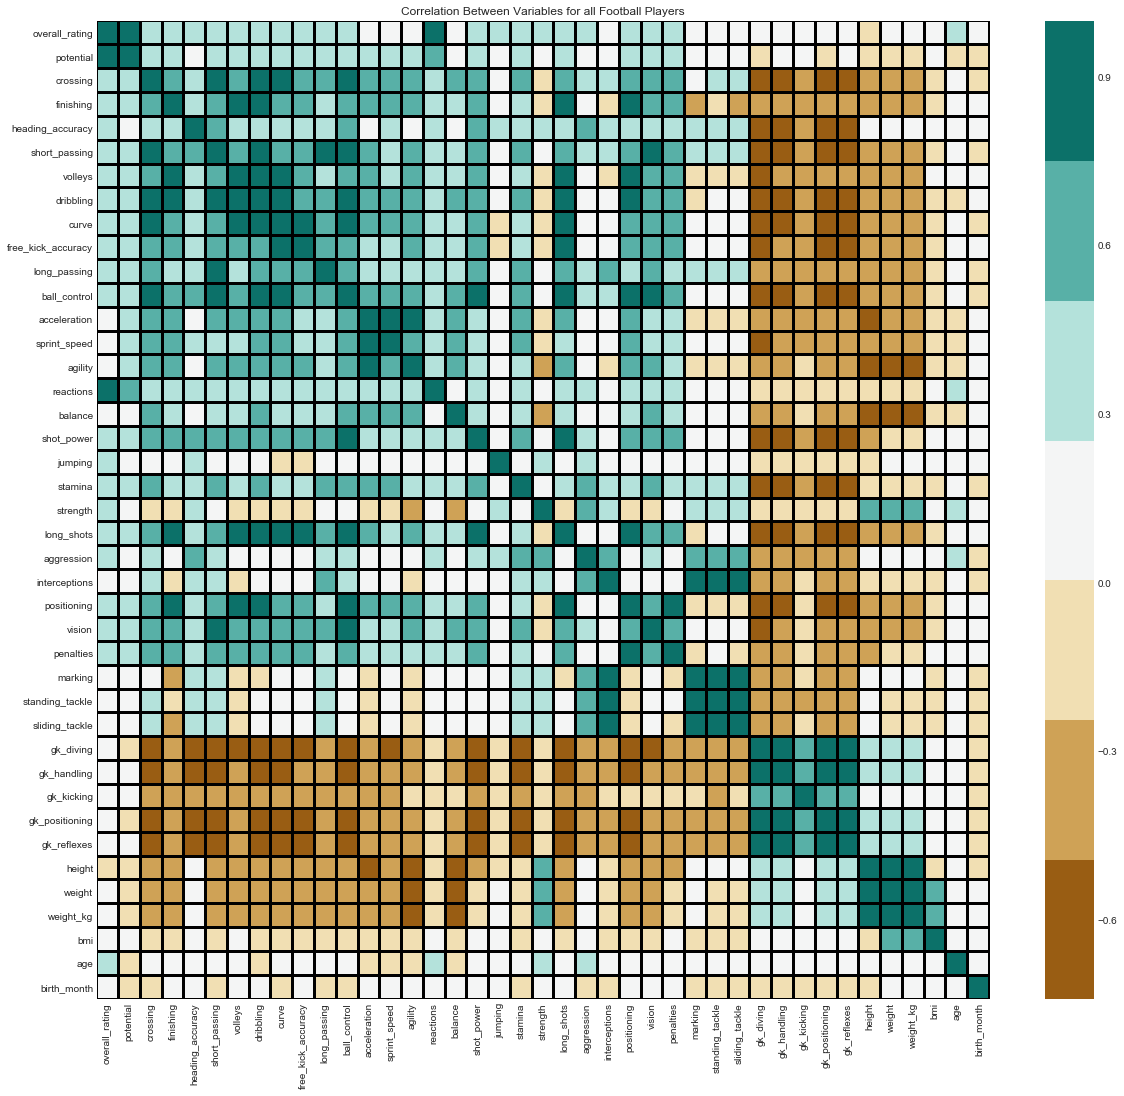

In [66]:
# Visualize the correlation matrix for the players' features

correlation = players.corr()
plt.figure(figsize=(20,18))
sns.heatmap(correlation,annot=False,fmt="f",linecolor="k",
            linewidths=2,cmap =sns.color_palette("BrBG", 7))

plt.title("Correlation Between Variables for all Football Players")
plt.show()

Correlation between overall rating and potential, reactions and dribbling respectively:
0.7654346716757741
0.7718560966627348
0.35419060093846744


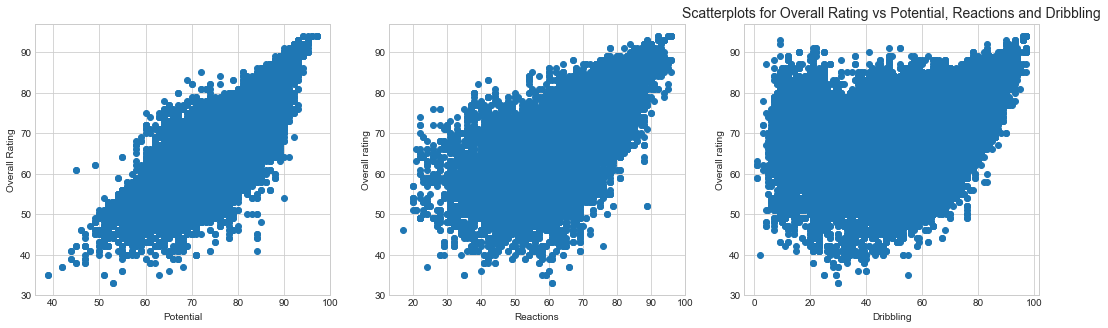

In [67]:
#Create scatterplot for overall rating and some FIFA variables: potential, reactions and dribbling

fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,3,1)
ax1.scatter(players['potential'], players['overall_rating'])
plt.xlabel('Potential')
plt.ylabel('Overall Rating')

ax2 = fig.add_subplot(1,3,2)
ax2.scatter(players['reactions'], players['overall_rating'])
plt.xlabel('Reactions')
plt.ylabel('Overall rating')

ax3 = fig.add_subplot(1,3,3)
ax3.scatter(players['dribbling'], players['overall_rating'])
plt.xlabel('Dribbling')
plt.ylabel('Overall rating')

plt.title('Scatterplots for Overall Rating vs Potential, Reactions and Dribbling', fontsize=14)

#Calculate Pearson correlation coefficient for overall rating vs potential,reactions and dribbling

print('Correlation between overall rating and potential, reactions and dribbling respectively:')

print(players['potential'].corr(players['overall_rating']))
print(players['reactions'].corr(players['overall_rating']))
print(players['dribbling'].corr(players['overall_rating']))

Although I expected a strong correlation between the overall rating and at least some of the more general player characteristics like strength or stamina, this is not always the case. In fact, only potential (which makes sense for high rated players) and reactions did show a very strong positive relationship with overall rating. 


In [68]:
#In the future, loop through numeric columns and store them in a list.
#Then, create another list to store the 'r' values for the correlation of those numeric columns against the potential
#Do the above using a for loop. Then we will have two lists that can be passed to a barplot to see strength of each feature.


#Create bar chart for skills that show the highest correlation with overall rating.


The remaining characteristics are all specific for goalkeepers, so I would like to correlate these characteristics only to the goalkeepers in the dataset. Unfortunately, there is no single identifier to separate the goalkeepers from the field players. I would have expected the columns with the goalkeeper characteristics to be empty for the field players but unfortunately that is not the case. At sofifa.com, the site that contains all the player ratings for EA Sports game FIFA 19, it appears that field players do not have a rating higher than 40 for the GK reflexes attribute, which means that if we filter the player data on gk_reflexes we should only have goalkeepers. To be on the safe side, I chose 50 (being roughly the mean of all players plus 2 times the standard deviation of all players in the gk_reflexes attribute) as a threshold for goalkeeping reflexes.



In [69]:
gk = players[players['gk_reflexes'] >= 50]
gk['player_name'].unique()

array(['Aaron Lennox', 'Abdoulaye Diallo', 'Achille Coser', 'Adam Bogdan',
       'Adam Collin', 'Adam Federici', 'Adrian', 'Adriano Facchini',
       'Alan Combe', 'Alan Mannus', 'Alan Martin', 'Alban Lafont',
       'Albano Benjamin Bizzarri', 'Alberto Brignoli',
       'Alberto Cifuentes', 'Alberto Frison,18', 'Alberto Garcia',
       'Alberto Maria Fontana', 'Alberto Pelagotti', 'Alberto Pomini',
       'Alessandro Damen', 'Alessandro Iacobucci', 'Alessio Cragno',
       'Alessio Scarpi', 'Alex Calderoni', 'Alex Manninger',
       'Alex McCarthy', 'Alex Valentini', 'Alexander Schwolow',
       'Alexander Stephan', 'Alexandre Letellier', 'Alexandros Tzorvas',
       'Alexis Thebaux', 'Alfonso De Lucia', 'Ali Ahamada',
       'Ali Al-Habsi', 'Alireza Haghighi', 'Allan McGregor',
       'Alphonse Areola', 'Anders Lindegaard', 'Andre Lenz',
       'Andre Moreira', 'Andrea Campagnolo', 'Andrea Consigli',
       'Andrea Guatelli', 'Andrea Seculin', 'Andreas Hirzel',
       'Andreas Isaks

Looking at the list of unique names in the goalkeepers dataset (see above), there are a lot of familiar (goalkeeper) names. Googling some random unknown names, we learn that we can safely assume that this is indeed a list of goalkeepers only. **- Could be improved by comparing with GOLD standard -i.e. official list of goalkeepers - need to search for this.**


Next, we can see which goalkeeper characteristics correlate most strongly with the overall rating of the goalkeeper in the same way that we did earlier as with all players in the dataset. 

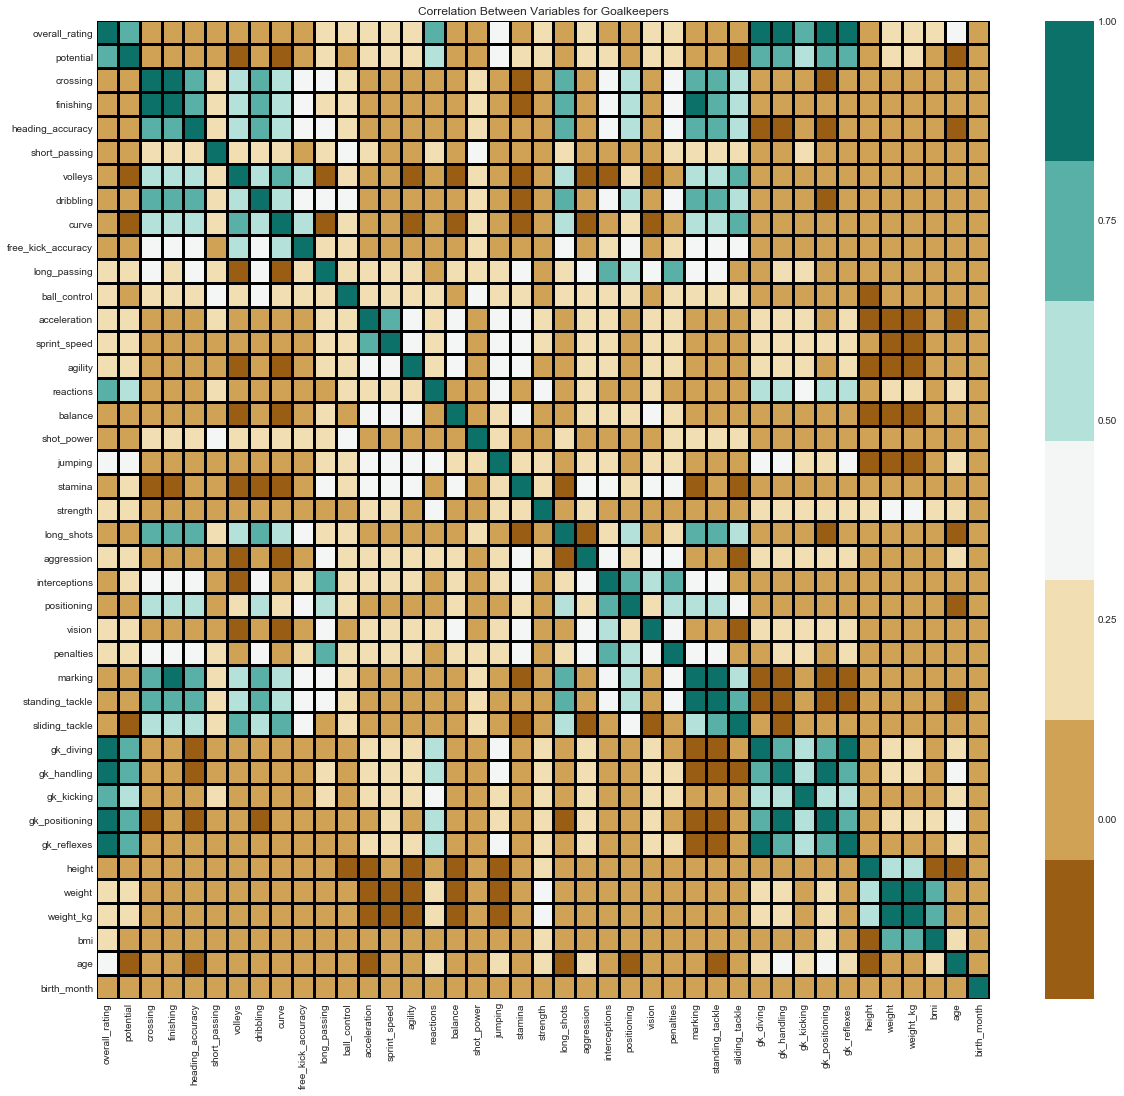

In [70]:
# Visualize the correlation matrix for goalkeepers' features

correlation = gk.corr()
plt.figure(figsize=(20,18))
sns.heatmap(correlation,annot=False,fmt="f",linecolor="k",
            linewidths=2,cmap =sns.color_palette("BrBG", 7))

plt.title("Correlation Between Variables for Goalkeepers")
plt.show()

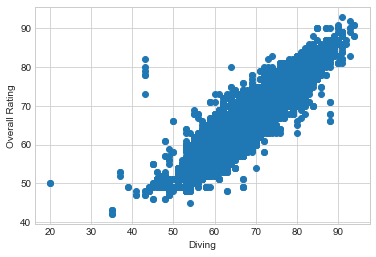

In [71]:
#Create scatterplot for overall rating and some FIFA variables: diving, handling, kicking, positioning, reflexes


plt.scatter(gk['gk_diving'], gk['overall_rating'])
plt.xlabel('Diving')
plt.ylabel('Overall Rating');

Text(0,0.5,'Overall Rating')

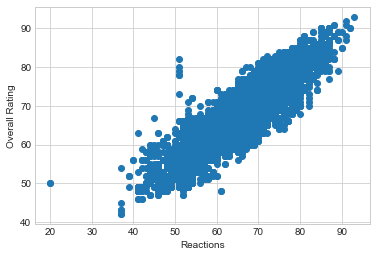

In [72]:
plt.scatter(gk['gk_handling'], gk['overall_rating'])
plt.xlabel('Reactions')
plt.ylabel('Overall Rating')

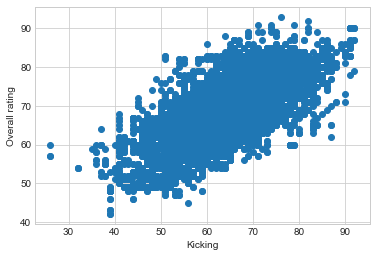

In [73]:
plt.scatter(gk['gk_kicking'], gk['overall_rating'])
plt.xlabel('Kicking')
plt.ylabel('Overall rating');

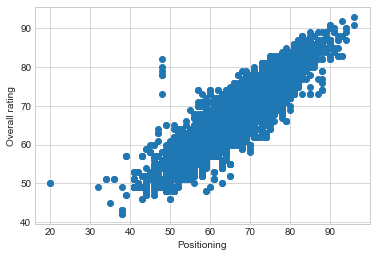

In [74]:
plt.scatter(gk['gk_positioning'], gk['overall_rating'])
plt.xlabel('Positioning')
plt.ylabel('Overall rating');

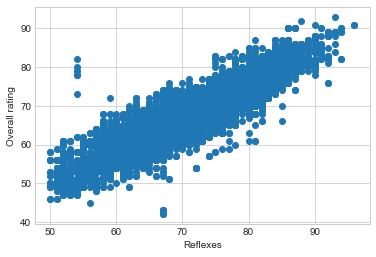

In [75]:
plt.scatter(gk['gk_reflexes'], gk['overall_rating'])
plt.xlabel('Reflexes')
plt.ylabel('Overall rating');

## Investigate Outliers

In the future investigate the outliers seen on the scatterplots. These players may not be goal-keepers after all!

In [76]:
#Calculate Pearson correlation coefficient for overall rating vs diving,handling, kicking, positioning and reflexes

print('Correlation between overall rating vs diving, handling, kicking, positioning and reflexes in their respective order:')

print(gk['gk_diving'].corr(players['overall_rating']))
print(gk['gk_handling'].corr(players['overall_rating']))
print(gk['gk_kicking'].corr(players['overall_rating']))
print(gk['gk_positioning'].corr(players['overall_rating']))
print(gk['gk_reflexes'].corr(players['overall_rating']))

Correlation between overall rating vs diving, handling, kicking, positioning and reflexes in their respective order:
0.9107220648600381
0.8936924253453692
0.7060300965191536
0.9017455894373972
0.9083217161232514


*Overview of Pearson correlation coefficient between overall rating and:*
 
* Diving: 0.91
* Handling: 0.89
* Kicking: 0.71
* Positioning: 0.90
* Reflexes: 0.91

As expected, all attributes that are specific to goalkeepers are strongly correlated with the overall rating of the goalkeeper. It is only the kicking skills that do not seem to display as high of a correlation coefficient as the other features do. Nevertheless, there is still a strong positive correlation with the overall rating for kicking skills.

In the future, it might be worth analysing all football players subgroups according to their position played in the field as the first heatmap revealed interesting correlations amongst variables that I suspect are closely linked with subgroups in the players dataset, these correspoding to the positions played by a football player. **player segementation by position**

## Player segmentation by performance

Next, we are going to be looking closer into the attributes that go together with a higher overall rating, we will be creating two sub-groups: one with a high overall rating (top 25% of players) and one with a low rating (bottom 25% of players). We will then see if there are any differences between the two sub-groups. In this analysis that follows, we will create an additional filter to leave out the goalkeepers, so that we only have field-players in the sub-groups. 

In [77]:
#Visualize the statistics of the players dataset
players.describe()


,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight,weight_kg,bmi,age,birth_month
count,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.00000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000
mean,68.635317,73.479457,55.142071,49.962136,57.263476,62.486726,49.488927,59.265755,53.001408,49.392783,57.084578,63.453846,67.709405,68.101628,65.995082,66.148297,65.190082,61.866474,66.977333,67.053401,67.432477,53.387560,60.946217,51.897374,55.730730,57.868176,54.933448,46.757433,50.354065,48.029342,14.696685,15.947786,20.526304,16.015043,16.32531,181.877895,168.774593,76.554868,23.117492,25.161993,5.961204
std,7.027950,6.581963,17.247231,19.041760,16.478716,14.172493,18.252319,17.741351,18.245476,17.820262,14.412035,15.187692,13.011580,12.585984,12.963670,9.145011,13.076192,16.129537,11.017828,13.200669,12.085131,18.370204,16.101618,19.483338,18.458218,15.152408,15.556645,21.226730,21.496289,21.592830,16.841454,15.841297,21.143898,16.070772,17.18545,6.398588,15.098388,6.848513,1.337586,4.719768,3.434750
min,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,3.000000,5.000000,10.000000,12.000000,11.000000,17.000000,12.000000,2.000000,14.000000,10.000000,10.000000,1.000000,6.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,157.480000,117.000000,53.070307,17.868393,7.000000,1.000000
25%,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,52.000000,41.000000,36.000000,49.000000,59.000000,61.000000,62.000000,58.000000,61.000000,58.000000,54.000000,60.000000,61.000000,60.000000,41.000000,51.000000,34.000000,45.000000,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.00000,177.800000,159.000000,72.121187,22.175771,22.000000,3.000000
50%,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,64.000000,56.000000,50.000000,59.000000,67.000000,69.000000,69.000000,68.000000,67.000000,67.000000,66.000000,68.000000,69.000000,69.000000,58.000000,64.000000,56.000000,60.000000,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.00000,182.880000,168.000000,76.203518,23.100858,25.000000,6.000000
75%,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,72.000000,67.000000,63.000000,67.000000,73.000000,77.000000,77.000000,75.000000,72.000000,74.000000,73.000000,74.000000,76.000000,76.000000,67.000000,73.000000,68.000000,69.000000,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.00000,185.420000,179.000000,81.193034,23.988885,28.000000,9.000000
max,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,97.000000,97.000000,97.000000,97.000000,96.000000,96.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,95.000000,97.000000,96.000000,94.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.00000,208.280000,243.000000,110.222946,30.865728,43.000000,12.000000


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


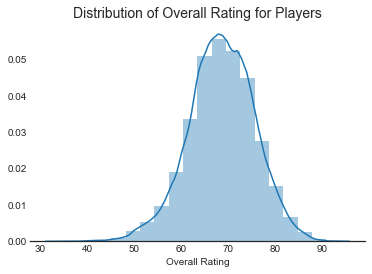

In [78]:
#Create distribution for attribute "overall rating" with kernel density estimation (KDE)


sns.set_style("white")
sns.distplot(players['overall_rating'], bins=20)
sns.despine(left=True)


plt.xlabel('Overall Rating')
plt.title('Distribution of Overall Rating for Players', fontsize=14);

In [79]:
#Create two subgroups from the players dataframe, based on the first and fourth quartile values for overall rating
#Exclude goalkeepers

top_players = players[(players['overall_rating'] > 73) & (players['gk_reflexes'] <= 40)]

bottom_players = players[(players['overall_rating'] < 64) & (players['gk_reflexes'] <= 40)]

In [80]:
#Descriptive statistics for the top players 
top_players.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight,weight_kg,bmi,age,birth_month
count,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000,40965.000000
mean,77.390846,80.425412,66.402173,61.393238,67.137264,74.169681,61.825729,71.221360,65.118296,60.622678,67.495276,75.682241,73.612279,73.961919,71.479556,75.446894,69.658709,73.461247,70.352228,74.323642,71.675381,65.969242,69.052069,60.516490,68.000146,69.236983,65.550983,52.705358,57.791285,54.560845,9.938801,11.494886,18.409472,11.481411,11.473624,181.175258,168.323252,76.350143,23.234713,26.691542,5.917930
std,3.203293,4.067879,13.468866,17.333100,12.577857,7.583528,16.170790,12.859475,15.304138,16.086753,11.065133,7.983775,11.253138,10.401303,11.971172,5.569219,12.362079,10.147063,10.961097,9.751874,11.569328,14.842395,13.832182,20.453973,15.242947,11.808822,12.962678,23.371014,22.635362,23.311201,3.413556,5.051522,20.581070,5.149520,5.162128,6.428243,14.970649,6.790572,1.322210,3.827990,3.402011
min,74.000000,60.000000,11.000000,10.000000,18.000000,32.000000,11.000000,16.000000,11.000000,10.000000,14.000000,15.000000,22.000000,24.000000,19.000000,39.000000,22.000000,7.000000,25.000000,26.000000,25.000000,10.000000,8.000000,11.000000,16.000000,16.000000,10.000000,7.000000,9.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,160.020000,123.000000,55.791862,18.359925,12.000000,1.000000
25%,75.000000,77.000000,60.000000,50.000000,59.000000,70.000000,53.000000,66.000000,57.000000,50.000000,61.000000,73.000000,68.000000,68.000000,65.000000,72.000000,62.000000,69.000000,64.000000,69.000000,65.000000,60.000000,61.000000,41.000000,63.000000,63.000000,58.000000,28.000000,35.000000,31.000000,7.000000,8.000000,8.000000,8.000000,8.000000,175.260000,159.000000,72.121187,22.377793,24.000000,3.000000
50%,77.000000,80.000000,70.000000,65.000000,69.000000,75.000000,66.000000,74.000000,68.000000,64.000000,69.000000,77.000000,75.000000,75.000000,73.000000,75.000000,72.000000,75.000000,71.000000,75.000000,74.000000,70.000000,72.000000,69.000000,73.000000,72.000000,68.000000,59.000000,67.000000,63.000000,10.000000,11.000000,11.000000,11.000000,11.000000,180.340000,168.000000,76.203518,23.220163,27.000000,6.000000
75%,79.000000,83.000000,76.000000,75.000000,77.000000,79.000000,74.000000,80.000000,76.000000,73.000000,75.000000,81.000000,81.000000,81.000000,79.000000,79.000000,78.000000,80.000000,78.000000,81.000000,79.000000,76.000000,79.000000,77.000000,78.000000,77.000000,75.000000,75.000000,78.000000,76.000000,13.000000,14.000000,14.000000,14.000000,14.000000,185.420000,179.000000,81.193034,24.101069,29.000000,9.000000
max,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,97.000000,97.000000,97.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,97.000000,96.000000,95.000000,97.000000,96.000000,94.000000,95.000000,95.000000,32.000000,33.000000,97.000000,33.000000,37.000000,203.200000,220.000000,99.790321,30.865728,41.000000,12.000000


In [81]:
#Descriptive statistics for the bottom players
bottom_players.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight,weight_kg,bmi,age,birth_month
count,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.00000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000,35717.000000
mean,59.090573,67.358317,49.080382,43.855755,52.791024,56.197497,43.171291,53.822437,46.522328,42.920710,50.104936,57.138897,65.595683,65.924294,63.321332,56.806367,64.270207,54.114483,63.160260,62.608394,61.727693,45.42540,54.870034,46.994316,49.051040,51.144721,48.960859,44.660554,47.709158,46.571493,9.520900,12.079542,17.448554,12.115043,11.988269,181.202193,165.694711,75.157857,22.872128,21.899768,5.868326
std,3.978516,5.650055,11.711083,14.824853,10.454492,9.190476,13.228894,11.852856,12.384599,12.273502,10.793875,8.466406,9.722151,9.475019,10.766753,7.344736,11.241960,12.344400,10.573578,10.180917,12.335999,13.49019,13.247807,14.696548,12.765259,11.449543,11.338902,16.336672,16.809249,17.124938,3.518672,5.291114,15.986205,5.259921,5.283761,6.007415,14.160355,6.423029,1.359690,4.683221,3.456308
min,33.000000,39.000000,8.000000,7.000000,2.000000,15.000000,5.000000,1.000000,11.000000,6.000000,11.000000,15.000000,22.000000,23.000000,22.000000,17.000000,21.000000,10.000000,21.000000,20.000000,13.000000,8.00000,10.000000,10.000000,8.000000,10.000000,8.000000,5.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,157.480000,117.000000,53.070307,17.868393,8.000000,1.000000
25%,57.000000,63.000000,41.000000,31.000000,46.000000,51.000000,33.000000,48.000000,37.000000,33.000000,43.000000,53.000000,60.000000,61.000000,57.000000,52.000000,58.000000,47.000000,57.000000,56.000000,55.000000,35.00000,46.000000,36.000000,42.000000,44.000000,42.000000,28.000000,31.000000,31.000000,7.000000,8.000000,8.000000,8.000000,8.000000,177.800000,154.000000,69.853225,22.083267,19.000000,3.000000
50%,60.000000,67.000000,51.000000,45.000000,54.000000,58.000000,44.000000,57.000000,47.000000,42.000000,52.000000,59.000000,66.000000,67.000000,64.000000,57.000000,65.000000,56.000000,63.000000,63.000000,62.000000,48.00000,57.000000,51.000000,52.000000,52.000000,50.000000,49.000000,54.000000,53.000000,9.000000,11.000000,11.000000,11.000000,11.000000,180.340000,165.000000,74.842741,22.813890,21.000000,6.000000
75%,62.000000,71.000000,58.000000,57.000000,61.000000,63.000000,53.000000,62.000000,56.000000,52.000000,58.000000,63.000000,72.000000,72.000000,71.000000,62.000000,72.000000,63.000000,71.000000,70.000000,71.000000,56.00000,64.000000,59.000000,58.000000,59.000000,57.000000,59.000000,62.000000,61.000000,12.000000,14.000000,15.000000,14.000000,14.000000,185.420000,174.000000,78.925072,23.709944,25.000000,9.000000
max,63.000000,90.000000,78.000000,79.000000,90.000000,90.000000,87.000000,83.000000,89.000000,91.000000,80.000000,84.000000,97.000000,97.000000,94.000000,89.000000,96.000000,87.000000,94.000000,94.000000,95.000000,83.00000,92.000000,89.000000,91.000000,91.000000,90.000000,78.000000,80.000000,83.000000,63.000000,63.000000,80.000000,63.000000,40.000000,208.280000,243.000000,110.222946,30.865728,39.000000,12.000000


Comparing the means of the numerical variables gives a good understanding of the skills you obviously need as a top player: the largest differences (>19 points in mean rating between top and bottom players) can be seen on the attributes long shots and shot power, followed by (>18 points difference in mean rating) ball control, reactions, positioning, vision, volleys and curve. 

To see the shape of the distributions, let us create two visuals below: one for an attribute that is typical for top players (finishing) and one for which the mean rating for top players is almost the same as for bottom players (sliding tackle). 



/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


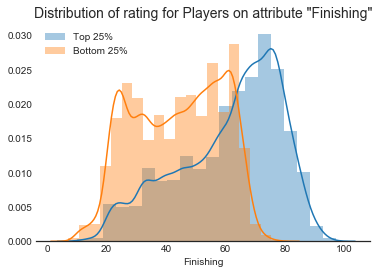

In [82]:
#Create histogram for attribute "finishing" with kernel density estimation (KDE)

labels = ['Top 25%', 'Bottom 25%']

sns.set_style("white")
sns.distplot(top_players['finishing'], bins=20)
sns.distplot(bottom_players['finishing'], bins=20)
sns.despine(left=True)

plt.legend(labels, loc = 'upper left')
plt.xlabel('Finishing')
plt.title('Distribution of rating for Players on attribute "Finishing"', fontsize=14);

The distribution for finishing is as I expected (bottom players to the left with lower rating, top players on the right).

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of rating for players on attribute "Sliding Tackle"')

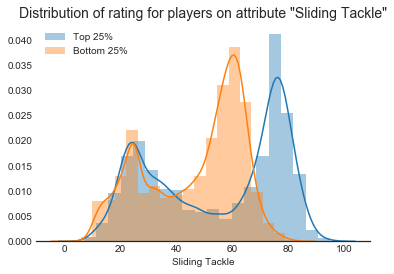

In [83]:
#Create histogram for attribute "sliding tackle" with kernel density estimation (KDE)

sns.set_style("white")
sns.distplot(top_players['sliding_tackle'], bins=20)
sns.distplot(bottom_players['sliding_tackle'], bins=20)
sns.despine(left=True)

plt.legend(labels, loc = 'upper left')
plt.xlabel('Sliding Tackle')
plt.title('Distribution of rating for players on attribute "Sliding Tackle"', fontsize=14)

In [84]:
#Print median for attribute "sliding tackle" in two groups
print(top_players['sliding_tackle'].median())
print(bottom_players['sliding_tackle'].median())

63.0
53.0


The distribution of the sliding tackles appears to be bimodal for the top players. It is a good example of a situation where just comparing the mean can be deceptive because when looking at the median for both groups, the top players once again come out as winners when it comes to their slide tackle skills. It is also interesting to realize that apparently, there are two pretty distinct groups: one group of top players who have poor sliding tackle skills (a plausible hypothesis would be that this group mainly consists of attackers) and one group of top players that have good sliding tackle skills (this group mainly consisting of defenders). 

Plotting the distribution of age of the top players and the bottom players (to be precise: the distribution of age at each moment a player is rated as top 25% or bottom 25%, which means that the same player can appear in this distribution more than once) we learn that top players are -on average- older than the bottom players. This can be explained by the fact that it will take some years before you reach your top ranking (i.e. your true potential), while the younger bottom players still have room for improvement. 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


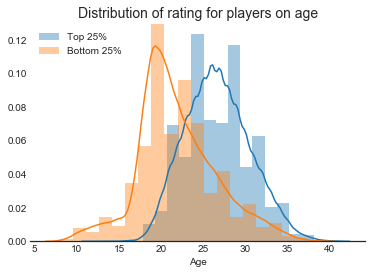

In [85]:
#Create histogram for age with kernel density estimation (KDE)

sns.set_style("white")
sns.distplot(top_players['age'], bins=20)
sns.distplot(bottom_players['age'], bins=20)
sns.despine(left=True)

plt.legend(labels, loc = 'upper left')
plt.xlabel('Age')
plt.title('Distribution of rating for players on age', fontsize=14);

As mentioned earlier, the same player can appear in the dataset multiple times. For the FIFA scores and age, this is not a problem, because they correspond to a certain moment in time (no player will be constant throughout his career). For height and weight, however, the data can be skewed if these constant values are included multiple times. Therefore, I will filter the data for unique player names.

In [86]:
#Filter data on unique field players, leave ranking date February 2007 (see earlier comment)

filtered_all = players[(players['date'].dt.year > 2007) & (players['gk_reflexes'] <= 40)]
unique_all = filtered_all.drop_duplicates(['player_name'])

#Descriptive statistics for weight, height and bmi for field players
unique_all[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,9375.000000,9375.000000,9375.000000
mean,181.254400,75.716445,23.025900
std,6.139524,6.509127,1.317792
min,157.480000,53.070307,17.868393
25%,177.800000,71.214002,22.150900
50%,180.340000,74.842741,23.012593
75%,185.420000,79.832257,23.869646
max,208.280000,110.222946,30.865728


In [87]:
#Filter data on unique goalkeepers, leave ranking date February 2007 (see earlier comment)

filtered_g = gk[(gk['date'].dt.year > 2007)]
unique_gk = filtered_g.drop_duplicates(['player_name'])

#Descriptive statistics for weight and height for goalkeepers
unique_gk[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,886.000000,886.000000,886.000000
mean,188.745508,83.664242,23.480090
std,4.697721,5.853611,1.331518
min,172.720000,63.956524,18.745276
25%,185.420000,79.832257,22.623217
50%,187.960000,83.007404,23.479133
75%,193.040000,87.089735,24.365990
max,208.280000,110.222946,29.578585


It is clear to see that goalkeepers are taller and heavier than field players, on average. This comes as no suprise: as it is usual for talent scouts to look for tall goalkeepers. 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


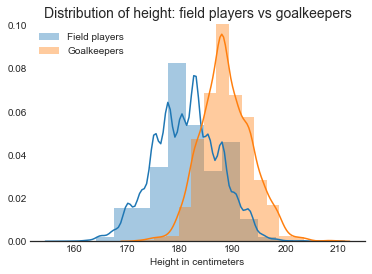

In [88]:
#Create histogram for height with kernel density estimation (KDE), comparing field players to goal keepers

sns.set_style("white")
sns.distplot(unique_all['height'], bins=15, label='Field players')
sns.distplot(unique_gk['height'], bins=15, label='Goalkeepers')

plt.legend(loc='upper left')
plt.xlabel('Height in centimeters')
plt.title('Distribution of height: field players vs goalkeepers', fontsize=14)
sns.despine(left=True);

Let's see if there is also a difference in weight and height between top and bottom players. 

In [89]:
#Decriptive statistics for unique players in the top 25% player group

filtered = top_players[(top_players['date'].dt.year > 2007)]
unique_top = top_players.drop_duplicates(['player_name'])

unique_top[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,3342.000000,3342.000000,3342.000000
mean,181.240628,76.289975,23.201741
std,6.290970,6.655869,1.315294
min,160.020000,55.791862,18.359925
25%,177.800000,72.121187,22.377793
50%,180.340000,76.203518,23.184609
75%,185.420000,81.193034,24.070645
max,203.200000,99.790321,30.865728


In [90]:
#Decriptive statistics for unique players in the bottom 25% player group

filtered_b = bottom_players[(bottom_players['date'].dt.year > 2007)]
unique_bottom = filtered_b.drop_duplicates(['player_name'])

unique_bottom[['height', 'weight_kg', 'bmi']].describe()

,height,weight_kg,bmi
count,5647.000000,5647.000000,5647.000000
mean,181.224300,75.255368,22.893921
std,6.048255,6.444633,1.322134
min,157.480000,53.070307,17.868393
25%,177.800000,71.214002,22.096473
50%,180.340000,74.842741,22.813890
75%,185.420000,79.832257,23.752351
max,208.280000,110.222946,30.865728


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


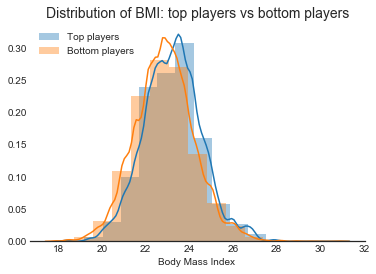

In [91]:
#Create histogram for BMI with kernel density estimation (KDE), compare top 25% players to bottom 25% players
#BMI is often used as a health metric

sns.set_style("white")
sns.distplot(top_players['bmi'], bins=15, label='Top players')
sns.distplot(bottom_players['bmi'], bins=15, label='Bottom players')

plt.legend(loc='upper left')
plt.xlabel('Body Mass Index ')
plt.title('Distribution of BMI: top players vs bottom players', fontsize=14)
sns.despine(left=True)

The tables above do not show any significant differences in weight and height for top players compared to bottom players.

There is one interesting (categorical) variable left to which the two player groups can be compared: preferred foot. Is there a difference in footedness between top and bottom players? This is a pretty difficult question to answer because to start with, there are no conclusive statistics on the percentage of footedness for all people but as a reference, I used the 19% leftfootedness found on [Wikipedia](https://en.wikipedia.org/wiki/Laterality).

right    0.754339
left     0.245661
Name: preferred_foot, dtype: float64
right    0.743758
left     0.256242
Name: preferred_foot, dtype: float64


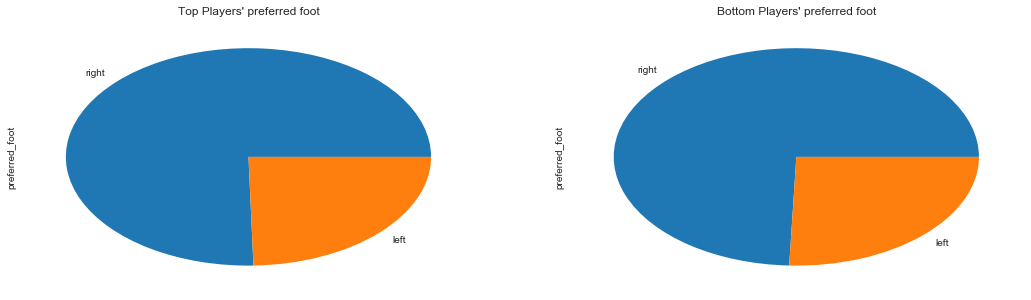

In [92]:
print(unique_top['preferred_foot'].value_counts(normalize=True))
print(unique_bottom['preferred_foot'].value_counts(normalize=True))

fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(1,2,1)

unique_top['preferred_foot'].value_counts(normalize=True).plot(kind='pie')
plt.title("Top Players' preferred foot" )

ax2 = fig.add_subplot(1,2,2)

unique_bottom['preferred_foot'].value_counts(normalize=True).plot(kind='pie')
plt.title("Bottom Players' preferred foot" );


Comparing this statistic to the statistics seen above, leftfootedness does seem to be more common among football players compared to the general population. Leftfootedness is seen a little more often among bottom players in this dataset.

At this moment in the course, I am not entirely sure which statistical method I can use to check if this difference is significant or not but I suspect it is a Chi square test. If I run a Chi square test online, I do find a significant difference in footedness between the whole population and both top and bottom players. This could be an indication that professional football players are more often leftfooted than people who do not play football (or, at least not on a professional level).

<a id='conclusions'></a>
## Conclusions

After trying many roads and angles within this extensive dataset, I singled out four research questions. Not every research question was answered to my full satisfaction. For example: I hoped to create a sharper image of the characteristics of top football players than I eventually found in the data. On the other hand, it was nice to see some research questions answered and visualized like I suspected beforehand, for example with the question about the relative birth effect. 

**A summary of my findings:**

*Matches*
* The much debated home advantage where football teams benefit from playing in their own stadium does seem to exist. There are differences between the various leagues, though. The cause of these differences is not clear. The hypothesis that the home advantage is larger in larger countries (with longer travel distances between clubs) is not backed up by the data. 
* Matching with my own observations between 2008 and 2016, the data did indeed show that FC Barcelona was successful in terms of points earned, compared to its eternal rival Real Madrid. However, FC Barcelona did not entirely live up to its reputation of having an offensive playing style because the team did not score the most goals in the majority of the seasons in the dataset. 

*Players*
* Looking at the months in which the professional football players in this dataset are born, it does seem that the relative age effect is present, because an overrepresentation of players born in the first months of the year can be observed. However, at this moment in time I do not have the tools to test if this overrepresentation is statistically significant or not.
* There is a strong correlation between the overall FIFA rating of the player and his reactions, which means that high overall ratings often go together with good reactions. Furthermore, the top 25% players have a larger mean rating on long shots and shot power, followed by ball control, reactions, positioning, vision, volleys and curve (as compared to the bottom 25% players). An important thing to keep in mind though is that these characteristics are no hard numbers but subjective ratings created for a video game. An interesting article on how the ratings are calculated can be found [here](https://www.vg247.com/2016/09/27/how-ea-calculates-fifa-17-player-ratings/).
* Goalkeepers are -on average- taller than field players. When comparing top to bottom players, there is no signficant difference in weight and height.
